<a href="https://colab.research.google.com/github/jal9o3/OLA/blob/dev/OLA_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load the data

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file, header=None)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx].values.astype(np.float32)
        input_data = row[:144].reshape(2, 8, 9)  # Reshaping to (2, 8, 9)
        output_data = row[147:]  # Selecting the 254 output values
        return torch.tensor(input_data), torch.tensor(output_data)

dataset = CustomDataset('training_data.csv')
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


# Define the model

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=16, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.fc1 = nn.Linear(32 * 4 * 5, 128)  # Adjust dimensions based on your architecture
        self.fc2 = nn.Linear(128, 254)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flattening
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Train the model

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming CNNModel and dataloader are already defined as per previous discussions

# Initialize the model
model = CNNModel()

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 20

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for inputs, targets in dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass
        loss.backward()

        # Optimize the weights
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()

    # Print average loss for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")

print("Training complete.")

Epoch [1/20], Loss: 0.0023
Epoch [2/20], Loss: 0.0012
Epoch [3/20], Loss: 0.0012
Epoch [4/20], Loss: 0.0012
Epoch [5/20], Loss: 0.0012
Epoch [6/20], Loss: 0.0012
Epoch [7/20], Loss: 0.0012
Epoch [8/20], Loss: 0.0012
Epoch [9/20], Loss: 0.0012
Epoch [10/20], Loss: 0.0012
Epoch [11/20], Loss: 0.0012
Epoch [12/20], Loss: 0.0012
Epoch [13/20], Loss: 0.0012
Epoch [14/20], Loss: 0.0012
Epoch [15/20], Loss: 0.0012
Epoch [16/20], Loss: 0.0012
Epoch [17/20], Loss: 0.0012
Epoch [18/20], Loss: 0.0012
Epoch [19/20], Loss: 0.0012
Epoch [20/20], Loss: 0.0012
Training complete.


# Save the model

In [4]:
torch.save(model.state_dict(), 'model.pth')

# Clone the OLA engine repository

In [5]:
!git clone https://github.com/jal9o3/OLA.git

Cloning into 'OLA'...
remote: Enumerating objects: 1025, done.
remote: Counting objects: 100% (267/267), done.
remote: Compressing objects: 100% (175/175), done.
remote: Total 1025 (delta 177), reused 170 (delta 91), pack-reused 758 (from 1)
Receiving objects: 100% (1025/1025), 381.51 KiB | 9.08 MiB/s, done.
Resolving deltas: 100% (638/638), done.


In [6]:
!cd OLA && git checkout dev

Branch 'dev' set up to track remote branch 'dev' from 'origin'.
Switched to a new branch 'dev'


# Define new match simulator to analyze winrate

In [7]:
import os
os.chdir('./OLA')

In [8]:
import random

import matplotlib.pyplot as plt

from OLA.core import Board, Infostate, Player
from OLA.constants import Controller
from OLA.training import (TimelessBoard, CFRTrainingSimulator, DirectionFilter,
                      ActionsFilter)
from OLA.simulation import MatchSimulator

class TestingController(Controller):
  """
  This adds the model as a new possible controller.
  """
  MODEL = 3


class ModelTestingSimulator(CFRTrainingSimulator):
  """
  This simulates a match that utilizes a trained OLA model.
  """

  def __init__(self, formations: list[list[int]], controllers: list[int],
                 save_data: bool, pov: int):
        super().__init__(formations, controllers, save_data, pov)
        self.controllers = controllers # Undo the nullification in superclass

  @staticmethod
  def get_model_decision(model, board: Board, infostate: Infostate,
                         actions_filter: ActionsFilter):
    """
    This is for obtaining the model's chosen action.
    """
    input_infostate = list(map(int, str(infostate).split(" ")))

    # Extract the first 144 elements and convert to a NumPy array
    input_data = np.array(input_infostate[:144], dtype=np.float32)

    # Reshape to (8, 9, 2)
    reshaped_data = input_data.reshape(8, 9, 2)

    # Transpose to (2, 8, 9) to match (C, H, W)
    transposed_data = np.transpose(reshaped_data, (2, 0, 1))

    # Convert to a PyTorch tensor and add a batch dimension to make it (1, 2, 8, 9)
    input_tensor = torch.tensor(transposed_data).unsqueeze(0)

    full_strategy = model(input_tensor)
    # Get the probabilities for each action from the model output
    full_strategy = full_strategy.squeeze(0).tolist()

    fullgame_actions = TimelessBoard.actions()
    valid_actions = board.actions()
    strategy = [0.0 for _ in range(len(valid_actions))]
    for action in fullgame_actions:
        if action not in valid_actions:
            full_strategy[fullgame_actions.index(action)] = 0.0
    if sum(full_strategy) > 0:
        full_strategy = [x / sum(full_strategy) for x in full_strategy]

    for i, action in enumerate(fullgame_actions):
        if action in valid_actions:
          strategy[valid_actions.index(action)] = full_strategy[i]
    if sum(strategy) <= 0:
        strategy = [1/len(valid_actions) for _ in range(len(valid_actions))]

    filtered_actions = actions_filter.filter()
    filtered_strategy = []
    for a, action in enumerate(valid_actions):
        if action in filtered_actions:
            filtered_strategy.append(strategy[a])
    normalizing_sum = sum(filtered_strategy)
    if normalizing_sum > 0:
        filtered_strategy = [
            p/normalizing_sum for p in filtered_strategy]
    else:
        # Reset options if all evaluated actions seem bad
        filtered_actions, filtered_strategy = valid_actions, strategy
    action = random.choices(
        filtered_actions, weights=filtered_strategy, k=1)[0]

    return action

  def get_controller_input(self, arbiter_board: Board, infostate: Infostate,
                           actions_filter: ActionsFilter):
      """
      This is for obtaining the controller's chosen action, be it human or
      bot.
      """
      action = "" # Initialize needed value
      valid_actions = arbiter_board.actions()
      if self.get_current_controller(arbiter_board) == Controller.RANDOM:
          action = random.choice(valid_actions)
      elif self.get_current_controller(arbiter_board) == Controller.HUMAN:
          while action not in valid_actions:
              action = input("Choose a move: ")
      elif self.get_current_controller(arbiter_board) == TestingController.MODEL:
          model = CNNModel()
          model.load_state_dict(torch.load('../model.pth'))
          model.eval()
          action = self.get_model_decision(model, arbiter_board, infostate,
                                           actions_filter)

      return action

  def start(self, iterations: int = 1, target: int = None):
    """
    This is the starting method for the match simulation.
    """
    model_wins = 0
    winning_data = [] # Initialize the data to plot
    for iteration in range(iterations):
      if ((self.player_one_color == Player.BLUE and self.controllers[0] != Controller.RANDOM)
          or (self.player_two_color == Player.BLUE and self.controllers[1] != Controller.RANDOM)):
        self.blue_formation = list(
                  Player.get_sensible_random_formation(
                      piece_list=Ranking.SORTED_FORMATION)
              )
      else:
        self.blue_formation = list(Player.get_random_formation(
            piece_list=Ranking.SORTED_FORMATION))

      if ((self.player_one_color == Player.RED and self.controllers[0] != Controller.RANDOM)
          or (self.player_two_color == Player.RED and self.controllers[1] != Controller.RANDOM)):
        self.red_formation = self._place_in_red_range(list(
            Player.get_sensible_random_formation(
                piece_list=Ranking.SORTED_FORMATION))
        )
      else:
        self.red_formation = self._place_in_red_range(list(
            Player.get_random_formation(
                piece_list=Ranking.SORTED_FORMATION))
        )
      arbiter_board = Board(self.setup_arbiter_matrix(),
                                    player_to_move=Player.BLUE,
                                    blue_anticipating=False, red_anticipating=False)
      blue_infostate, red_infostate = MatchSimulator._starting_infostates(
                  arbiter_board)
      action, result, previous_action, previous_result, attack_location = (
                  "", "", "", "", None)  # Initialize needed values
      turn_number = 1
      branches_encountered = 0
      while not arbiter_board.is_terminal():
          self.manage_pov_switching(arbiter_board)

          MatchSimulator._print_game_status(turn_number, arbiter_board,
                                            infostates=[
                                                blue_infostate,
                                                red_infostate],
                                            pov=self.pov)
          valid_actions = arbiter_board.actions()
          branches_encountered += len(valid_actions)

          action = ""  # Initialize variable for storing chosen action
          relevant_infostate = (blue_infostate if arbiter_board.player_to_move == Player.BLUE
                                else red_infostate)

          # For the first turns of each player, choose a forward move
          if turn_number in [1, 2]:
              actions_filter = ActionsFilter(state=arbiter_board, directions=DirectionFilter(
                  back=False, right=False, left=False),
                  square_whitelist=[(x, y) for y in range(Board.COLUMNS)
                                    for x in range(Board.ROWS)])
          else:
              actions_filter = CFRTrainingSimulator._get_actions_filter(
                  arbiter_board, previous_action, previous_result, attack_location)

          action = self.get_controller_input(arbiter_board, relevant_infostate,
                                            actions_filter)
          print(f"Chosen Move: {action}")
          previous_action = action  # Store for the next iteration

          new_arbiter_board = arbiter_board.transition(action)
          arbiter_board, result, attack_location = self._process_action(
                      arbiter_board, action)
          previous_result = result  # Store for the next iteration
          blue_infostate, red_infostate = MatchSimulator._update_infostates(
              blue_infostate, red_infostate, action=action, result=result
          )
          arbiter_board = new_arbiter_board
          turn_number += 1

          print(f"Model Wins: {model_wins}")
          print(f"Iteration: {iteration + 1}/{iterations}")

      MatchSimulator._print_result(arbiter_board)
      match_result = MatchSimulator._get_match_result(arbiter_board)
      if match_result == self.player_two_color: # Model controller is Player 2
        model_wins += 1
      model_color = "BLUE" if self.player_two_color == Player.BLUE else "RED"
      print(f"Model: {model_color}")

      winning_data.append([model_wins, iteration + 1])

    print(f"Model Winrate: {(model_wins/iterations)*100: .2f}")

    # Calculate the percentage ratios
    percentages = [(a / b) * 100 for a, b in winning_data]

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(percentages, marker='o', linestyle='-', color='b')
    plt.title('Win Rate over Measurement Iterations')
    plt.xlabel('Iteration #')
    plt.ylabel('Measured Win Rate (%)')
    plt.grid(True)
    plt.show()

Streaming output truncated to the last 5000 lines.

 0  b6 bB b4  - b2  - b5 b1 b2 
 1   - bE b2  - b2 b3 bF b2 bF 
 2   -  -  - bA  -  -  -  - b7 
 3   - bD  -  -  -  -  -  -  - 
 4   -  -  -  - r2  -  -  -  - 
 5   - r2 b9 b8  -  -  - r4 r2 
 6  r9  -  - rA r2  - r1 rF  - 
 7  rE rF rD  - rB  -  -  -  - 

     0  1  2  3  4  5  6  7  8 
Player to move: 1
Chosen Move: 5343
Model Wins: 434
Iteration: 499/500
Turn Number: 94

 0  b6 bB b4  - b2  - b5 b1 b2 
 1   - bE b2  - b2 b3 bF b2 bF 
 2   -  -  - bA  -  -  -  - b7 
 3   - bD  -  -  -  -  -  -  - 
 4   -  -  - b8 r2  -  -  -  - 
 5   - r2 b9  -  -  -  - r4 r2 
 6  r9  -  - rA r2  - r1 rF  - 
 7  rE rF rD  - rB  -  -  -  - 

     0  1  2  3  4  5  6  7  8 
Player to move: 2
Chosen Move: 6665
Model Wins: 434
Iteration: 499/500
Turn Number: 95

 0  b6 bB b4  - b2  - b5 b1 b2 
 1   - bE b2  - b2 b3 bF b2 bF 
 2   -  -  - bA  -  -  -  - b7 
 3   - bD  -  -  -  -  -  -  - 
 4   -  -  - b8 r2  -  -  -  - 
 5   - r2 b9  -  -  -  - r4 r2 
 6

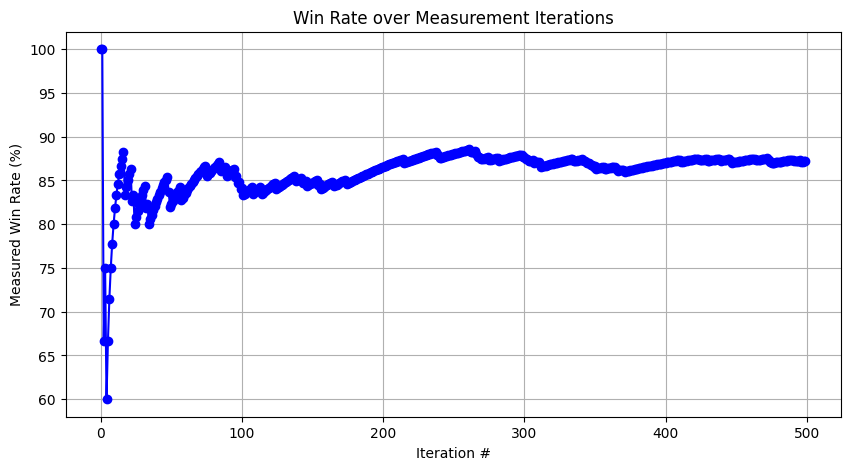

In [9]:
from OLA.constants import Ranking, Controller, POV

# Sample random formations
blue_formation = list(
    Player.get_sensible_random_formation(
        piece_list=Ranking.SORTED_FORMATION)
)
red_formation = list(
    Player.get_sensible_random_formation(
        piece_list=Ranking.SORTED_FORMATION)
)

match_simulator = ModelTestingSimulator(formations=[blue_formation, red_formation],
                                  controllers=[
                                      Controller.RANDOM, TestingController.MODEL],
                                  save_data=False,
                                  pov=POV.WORLD)
match_simulator.start(iterations=500)